In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import yaml

config_path = 'config_linear_100_gan_transformer.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [4]:
train_loss_output_path = 'output_linear_100/train_loss_linear_100.npy'
test_loss_output_path = 'output_linear_100/test_loss_linear_100.npy'
model_output_path = 'output_linear_100/model_linear_100.pth'

In [5]:
train_losses = np.load(train_loss_output_path)
test_losses = np.load(test_loss_output_path)

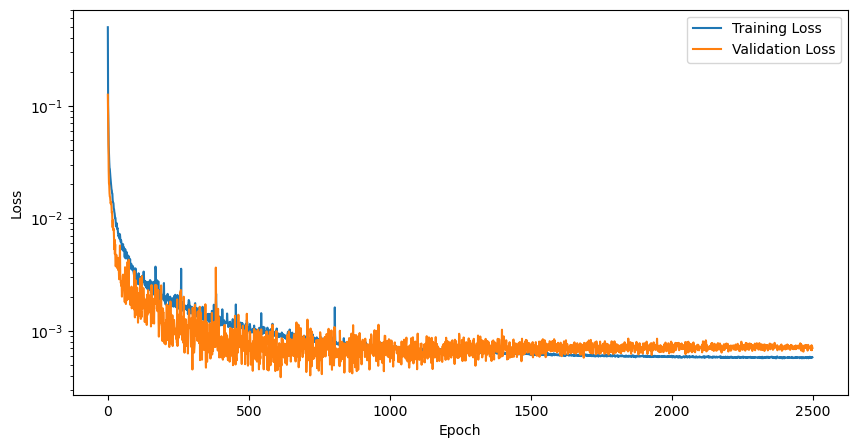

In [6]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [7]:
from train import *
import torch
predict_num = 10
train_dataset, test_dataset, n_features, n_inputs = data_preparation_v2(config)
params = Params(n_features, n_inputs)
model = build_model_position_emb(params)
model = torch.load(model_output_path)

['/home/shiqi/code/model_combination_Argos/gan_transformer', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '../utils']
(6550, 10, 6957)
(6550, 10, 6957)


In [8]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [9]:
for batch in train_loader:
    x_train, y_train, u1_train, u2_train = batch

In [10]:
y_pred_scaled = model(x_train, u1_train, u2_train).detach().numpy()
y_pred = scaler_x.inverse_transform(y_pred_scaled.reshape(-1, n_features))

In [11]:
y_true = scaler_x.inverse_transform(y_train.detach().numpy().reshape(-1, n_features))

In [12]:
err = y_pred - y_true
err_norm = np.linalg.norm(err)
y_true_norm = np.linalg.norm(y_true)
ratio = err_norm / y_true_norm
print(ratio)


0.0232499


In [13]:
predict_num = config['predict_num']
window_size = config['window_size']
data_dir = config['data_dir']

# Data preparation
x_dataset = []
y_dataset = []
u1_dataset = []
u2_dataset = []


for item in os.listdir(data_dir):
    data_file_path = os.path.join(data_dir, item)

    # Check if the file exists before trying to load it
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, y_data, u1_data, u2_data = load_dataset(data_dict, predict_num)
        x_dataset.append(x_data[:window_size])
        u1_dataset.append(u1_data[:window_size])
        u2_dataset.append(u2_data[:window_size])
        y_dataset.append(y_data[:window_size])
    else:
        print(f"File not found: {data_file_path}")

In [14]:
len(x_dataset)

50

In [15]:
# start from the zero point
y_data_pred_50traj_10predict = []
y_data_pred_50traj_10predict_scaled = []
x_dataset_scaled = []
for x_data, u1_data, u2_data in zip(x_dataset, u1_dataset, u2_dataset):
    steps = int(window_size / predict_num)
    n_target = x_data.shape[1]
    x_data_scaled = scaler_x.transform(x_data)
    u1_data_scaled = scaler_u.transform(u1_data)
    u2_data_scaled = scaler_u.transform(u2_data)
    y_data_pred_scaled = [torch.tensor(x_data_scaled[0:predict_num,:], dtype = torch.float32)]
    for step in range(steps - 1):
        # print(step)
        x = torch.tensor(y_data_pred_scaled[-1].reshape((1, predict_num, -1)),dtype = torch.float32)
        u1 = torch.tensor(u1_data_scaled[predict_num * step: predict_num * (step + 1), :].reshape((1, predict_num, -1)), dtype = torch.float32)
        u2 = torch.tensor(u2_data_scaled[predict_num * step: predict_num * (step + 1), :].reshape((1, predict_num, -1)), dtype = torch.float32)
        y_pred = model(x, u1, u2)
        y_data_pred_scaled.append(y_pred.reshape(predict_num, -1))
    y_data_pred_scaled = torch.cat(y_data_pred_scaled, dim = 0).detach().numpy()
    # print(np.shape(y_data_pred_scaled))
    y_data_pred = scaler_x.inverse_transform(y_data_pred_scaled)
    y_data_pred_50traj_10predict_scaled.append(y_data_pred_scaled)
    x_dataset_scaled.append(x_data_scaled)
    y_data_pred_50traj_10predict.append(y_data_pred)


In [16]:
errors = [y_data_pred_50traj_10predict[i] - x_dataset[i][:(steps * predict_num), :] for i in range(len(y_data_pred_50traj_10predict))]

cumulative_error_norms = [np.array([np.linalg.norm(errors[i][:j+1,:]) for j in range(errors[i].shape[0])]) for i in range(len(errors))]

data_norms = [np.linalg.norm(x_dataset[i]) for i in range(len(x_dataset))]

relative_errors = [cumulative_error_norms[i] / data_norms[i] for i in range(len(cumulative_error_norms))] 

In [17]:
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)   

In [18]:
np.where(np.array(relative_errors)[:, -1]>0.03)

(array([ 5, 17, 40]),)

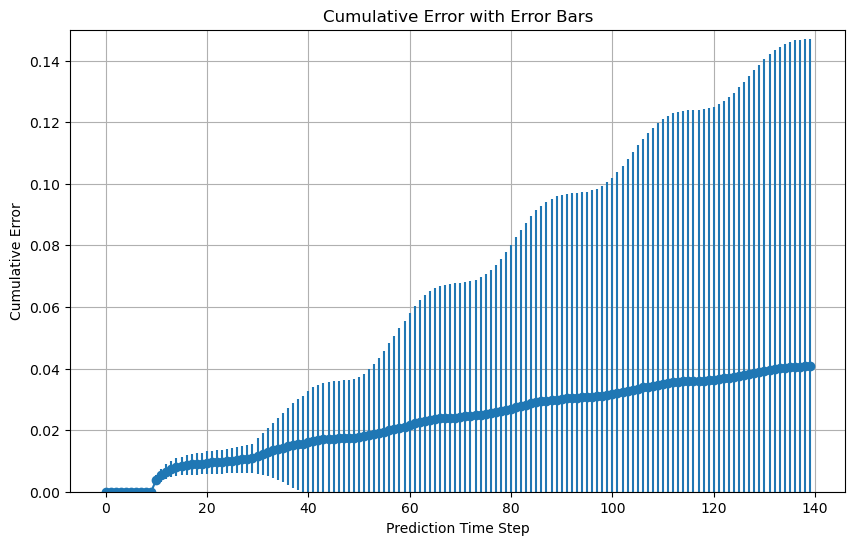

In [19]:
# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(steps * predict_num), mean_relative_errors, yerr=std_relative_errors, fmt='-o')
plt.xlabel('Prediction Time Step')
plt.ylabel('Cumulative Error')
plt.ylim(0, 0.15)
plt.title('Cumulative Error with Error Bars')
plt.grid(True)
plt.show()

In [20]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(x_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]

In [21]:
np.mean(domain_relative_error)

0.040709094205788506

In [22]:
np.std(domain_relative_error)

0.10628664059214847

In [23]:
x_dataset[0].shape

(140, 6957)

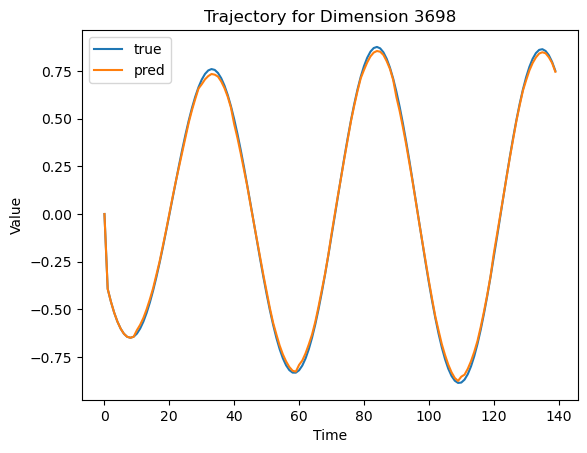

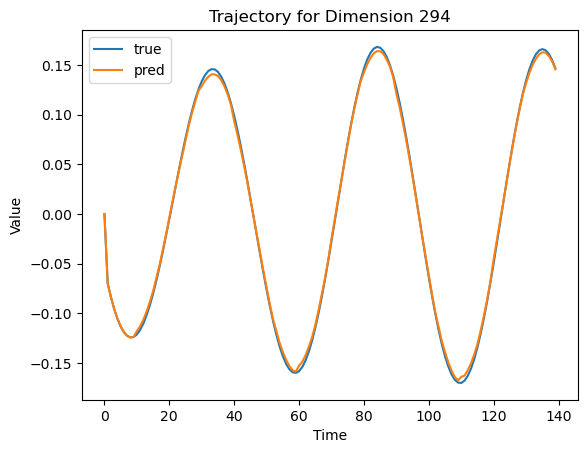

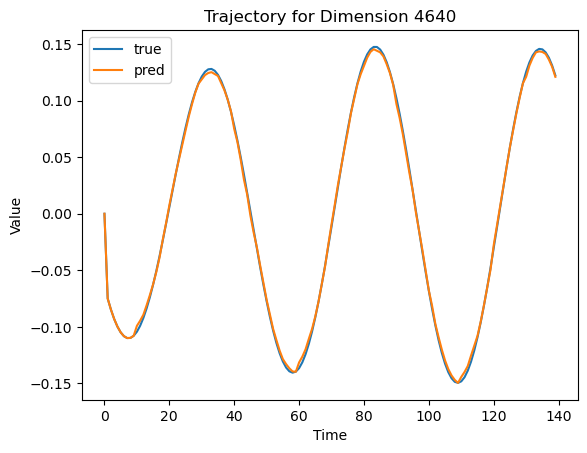

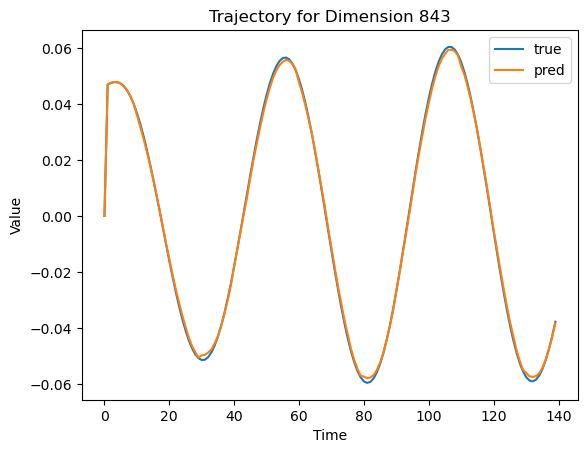

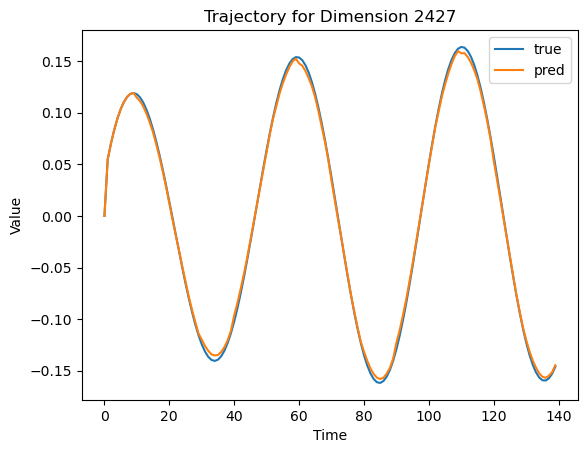

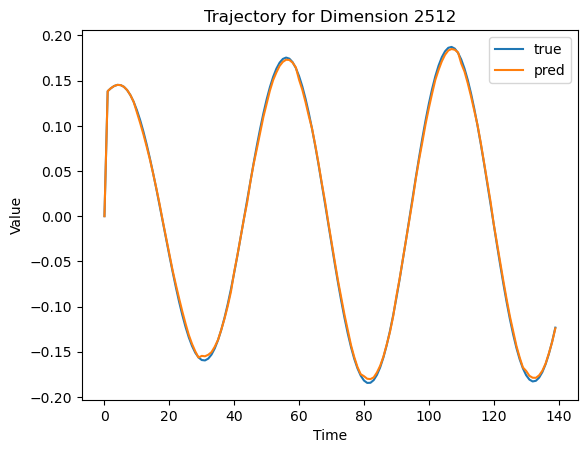

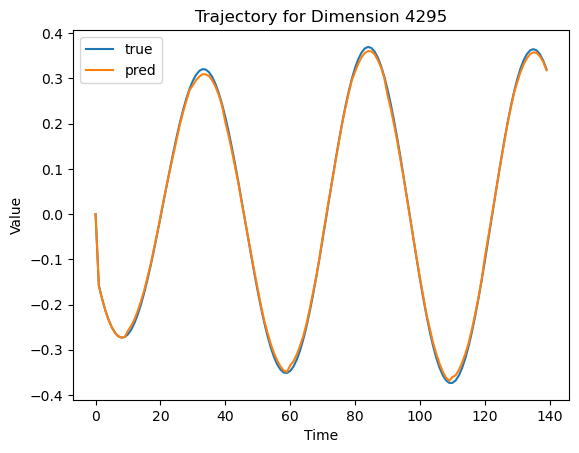

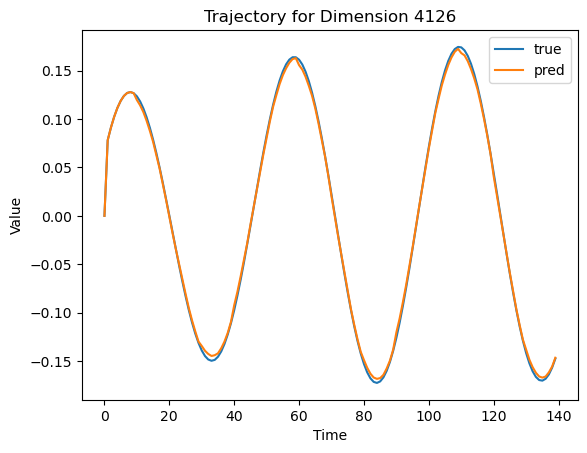

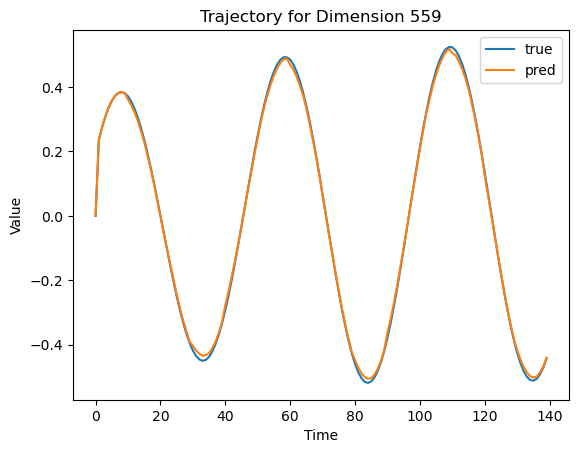

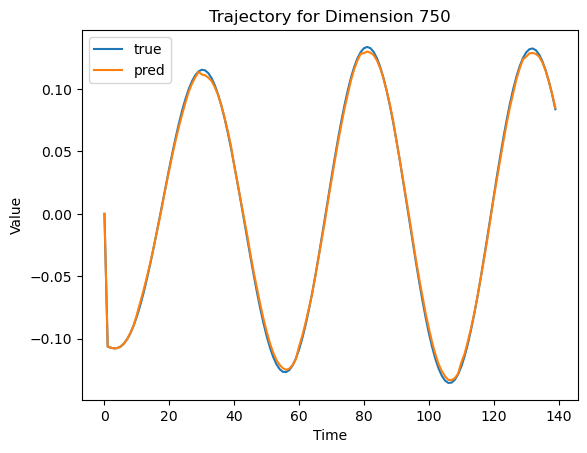

In [24]:
import numpy as np
import matplotlib.pyplot as plt

n_dimensions = x_dataset[1].shape[1]
selected_dimensions = np.random.choice(n_dimensions, 10, replace=False)
# selected_dimensions[-1] = 3229
# selected_dimensions = range(10)

for i in selected_dimensions:
    plt.figure()
    y_true = x_dataset[1]
    y_pred = y_data_pred_50traj_10predict[1]
    plt.plot(y_true[:, i], label = 'true')
    plt.plot(y_pred[:, i], label = 'pred')
    plt.title(f'Trajectory for Dimension {i}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [25]:
errors = [y_data_pred_50traj_10predict[i] - x_dataset[i][:, :] for i in range(len(y_data_pred_50traj_10predict))]

ratios_all = np.zeros((len(errors), 6957))

for i in range(len(errors)):
    reference = x_dataset[i][:(steps * predict_num), :]
    error = errors[i]
    reference_norms = np.linalg.norm(reference, axis=0)
    error_norms = np.linalg.norm(error, axis=0)
    # print(error_norms)
    ratios_all[i] = error_norms / reference_norms

# 计算平均比值和标准差
mean_ratios = np.mean(ratios_all, axis=0)
std_ratios = np.std(ratios_all, axis=0)

mean_ratios, std_ratios

(array([0.03712548, 0.03706122, 0.03712782, ..., 0.06981824, 0.07116092,
        0.07151691]),
 array([0.1060723 , 0.1060972 , 0.10607132, ..., 0.09785209, 0.09757568,
        0.09749435]))

In [26]:
ratios_all[0]

array([0.02496688, 0.0248221 , 0.02497047, ..., 0.06279804, 0.06428612,
       0.06476634])

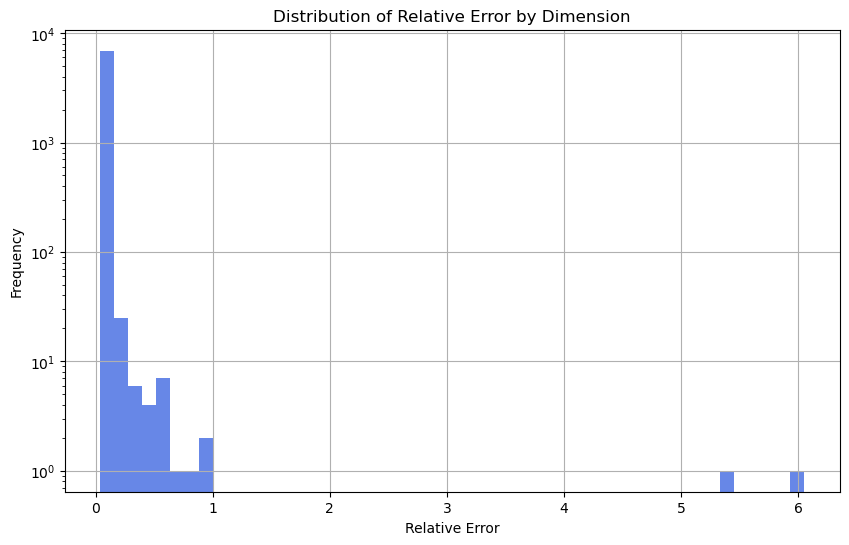

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(mean_ratios, bins=50, alpha=0.8, color='royalblue')
plt.title('Distribution of Relative Error by Dimension')
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()

In [28]:
max(mean_ratios)

6.052400846696513

In [29]:
mean_value = np.mean(mean_ratios)
print(mean_value)
count_above_mean = np.sum(mean_ratios > 0.2)
count_above_mean

0.049731922510494395


37

In [30]:
indexes_large_error = np.where(mean_ratios > 0.5)
indexes_large_error

(array([3115, 3116, 3133, 3134, 3206, 3297, 4477, 4478, 4809, 4920, 4921,
        5459, 5819, 5820]),)

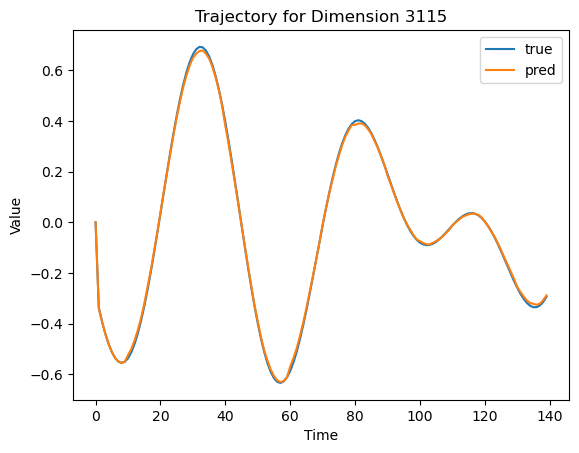

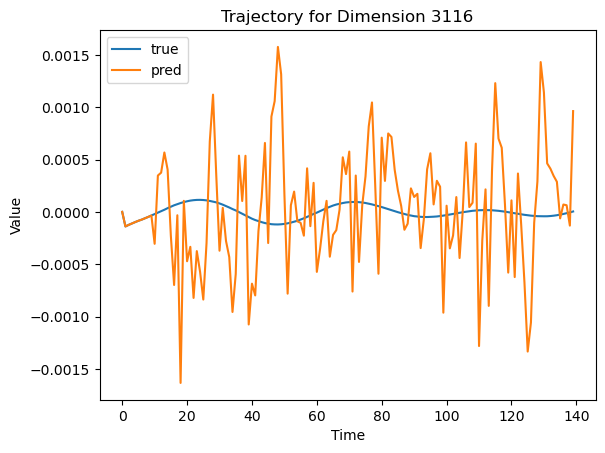

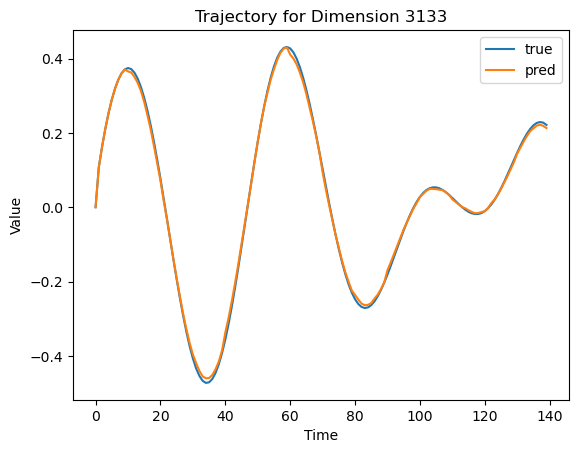

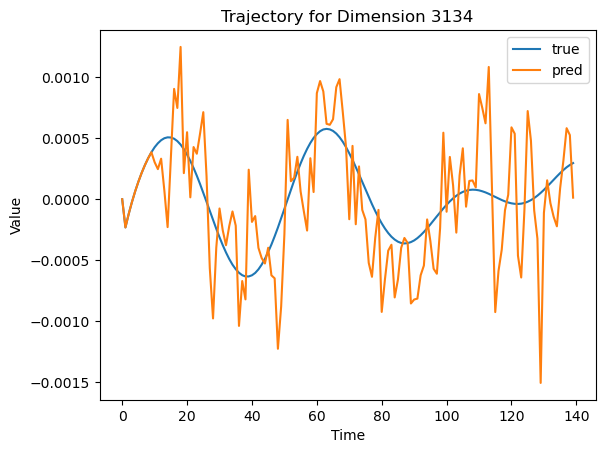

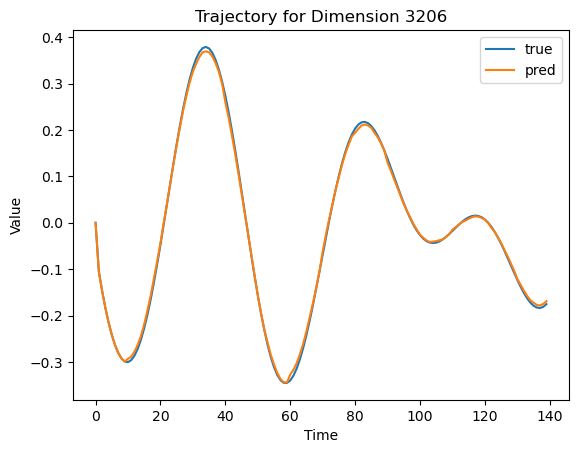

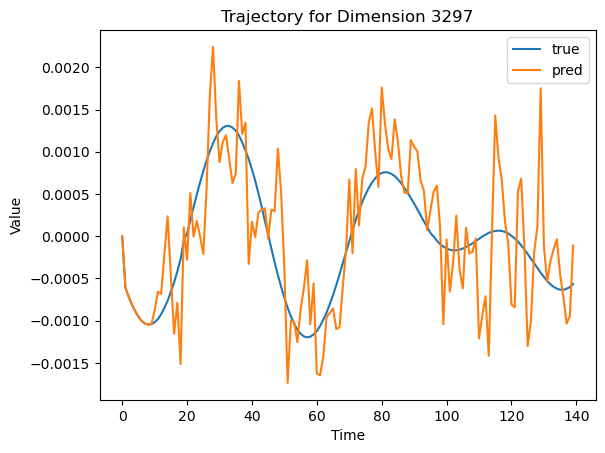

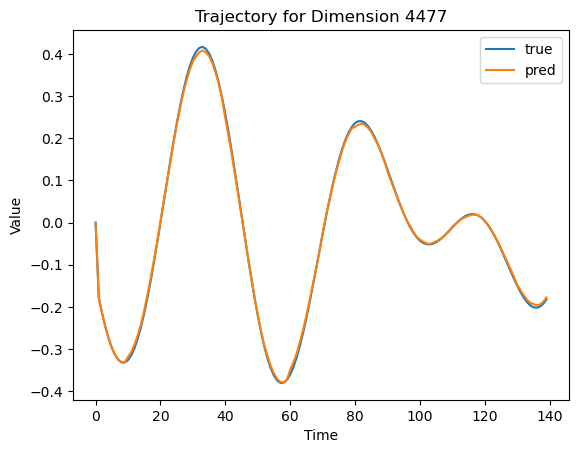

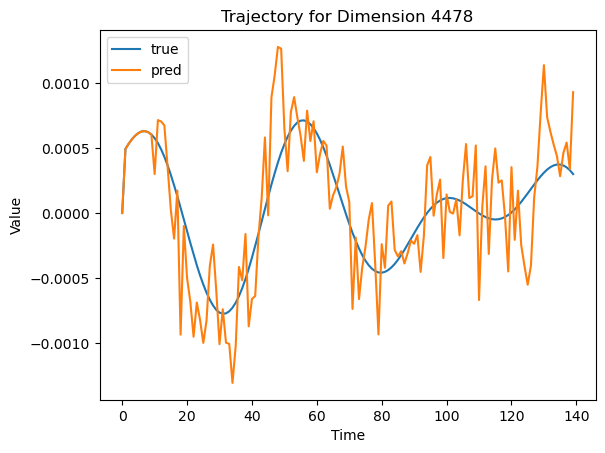

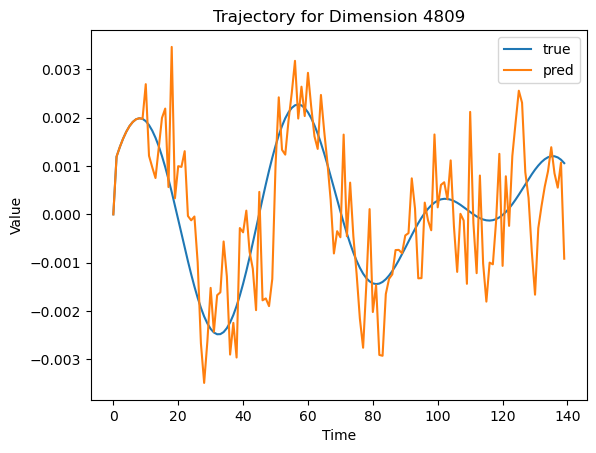

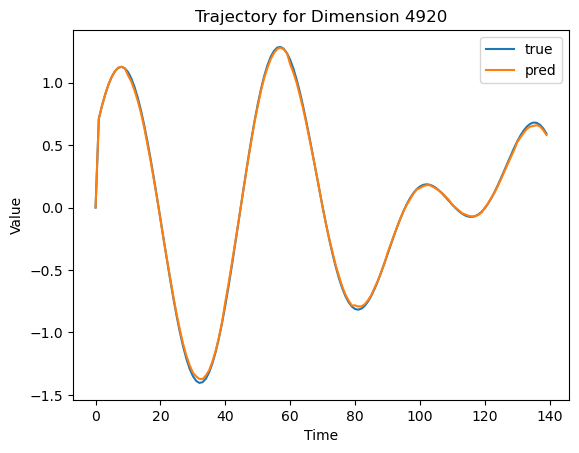

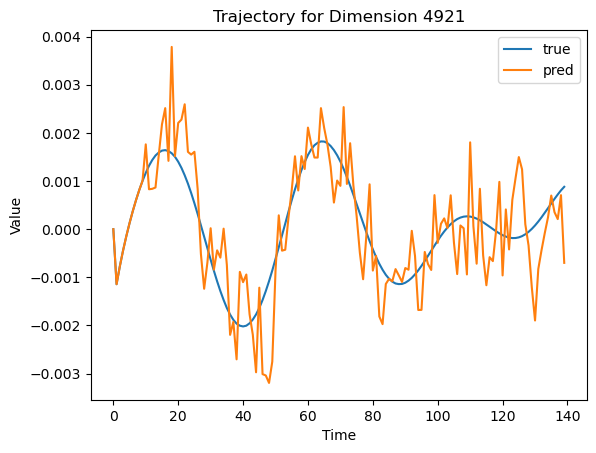

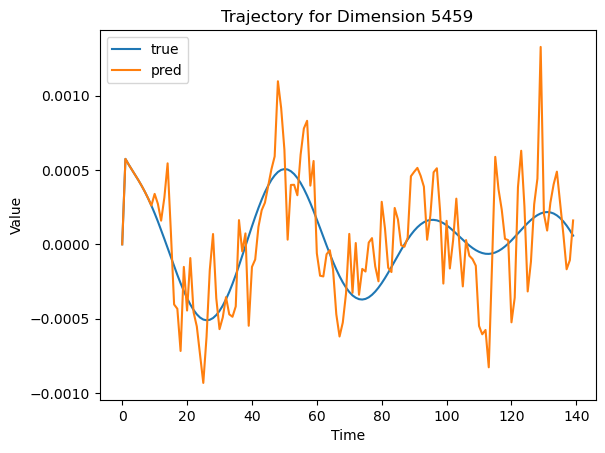

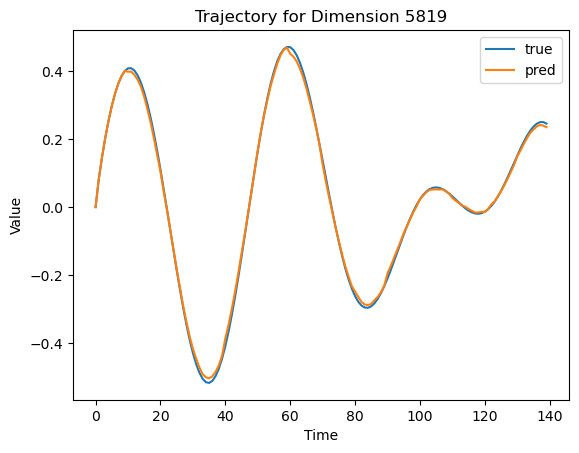

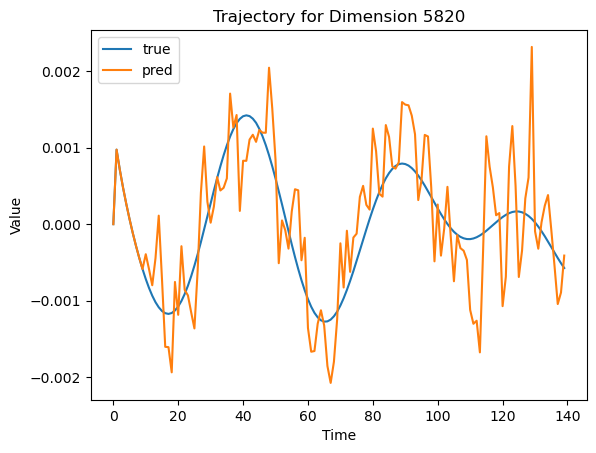

In [31]:
idx = 39
n_dimensions = x_dataset[idx].shape[1]
selected_dimensions = indexes_large_error[0]

for i in selected_dimensions:
    plt.figure()
    y_true = x_dataset[idx]
    y_pred = y_data_pred_50traj_10predict[idx]
    plt.plot(y_true[:, i], label = 'true')
    plt.plot(y_pred[:, i], label = 'pred')
    plt.title(f'Trajectory for Dimension {i}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

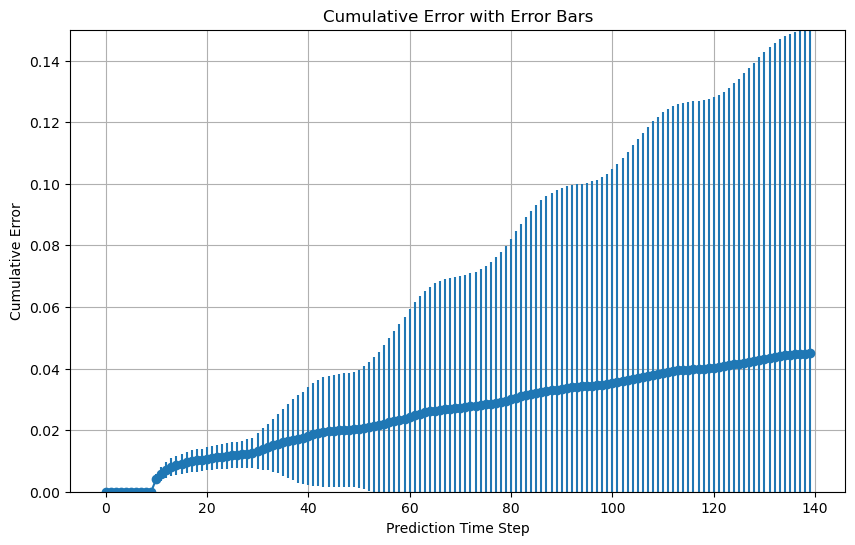

In [32]:
# Test for scaled data

errors_scaled = [y_data_pred_50traj_10predict_scaled[i] - x_dataset_scaled[i][:(steps * predict_num), :] for i in range(len(y_data_pred_50traj_10predict_scaled))]
cumulative_error_norms_scaled = [np.array([np.linalg.norm(errors_scaled[i][:j+1,:]) for j in range(errors_scaled[i].shape[0])]) for i in range(len(errors_scaled))]
data_norms_scaled = [np.linalg.norm(x_dataset_scaled[i]) for i in range(len(x_dataset_scaled))]
relative_errors_scaled = [cumulative_error_norms_scaled[i] / data_norms_scaled[i] for i in range(len(cumulative_error_norms_scaled))]
mean_relative_errors_scaled = np.mean(relative_errors_scaled, axis=0)
std_relative_errors_scaled = np.std(relative_errors_scaled, axis=0)
plt.figure(figsize=(10, 6))
plt.errorbar(range(steps * predict_num), mean_relative_errors_scaled, yerr=std_relative_errors_scaled, fmt='-o')
plt.xlabel('Prediction Time Step')
plt.ylabel('Cumulative Error')
plt.ylim(0, 0.15)
plt.title('Cumulative Error with Error Bars')
plt.grid(True)

[0.03715453 0.03708985 0.03715687 ... 0.06982355 0.07116356 0.07151887] [0.10573883 0.10576331 0.10573791 ... 0.09784291 0.09757142 0.09749126]


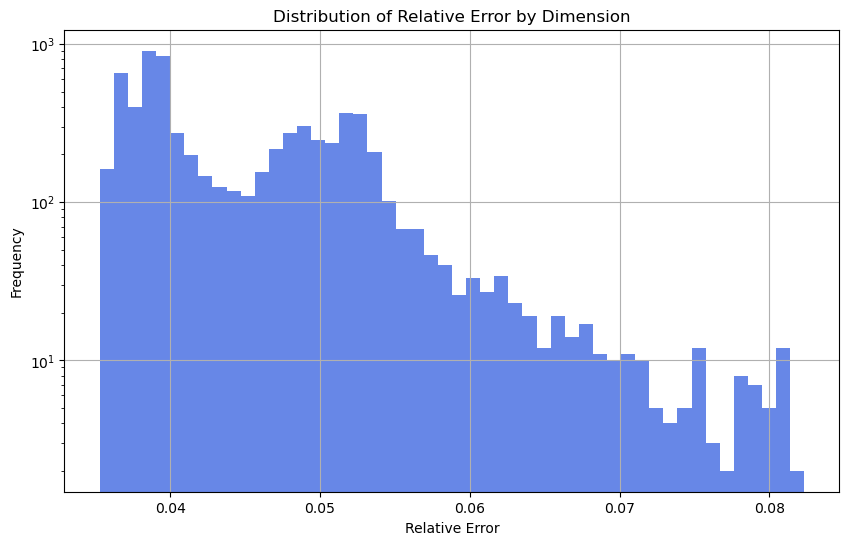

In [33]:
errors_scaled = [y_data_pred_50traj_10predict_scaled[i] - x_dataset_scaled[i][:, :] for i in range(len(y_data_pred_50traj_10predict_scaled))]
ratios_all_scaled = np.zeros((len(errors_scaled), 6957))

for i in range(len(errors_scaled)):
    reference = x_dataset_scaled[i][:(steps * predict_num), :]
    error = errors_scaled[i]
    reference_norms = np.linalg.norm(reference, axis=0)
    error_norms = np.linalg.norm(error, axis=0)
    ratios_all_scaled[i] = error_norms / reference_norms

mean_ratios_scaled = np.mean(ratios_all_scaled, axis=0)
std_ratios_scaled = np.std(ratios_all_scaled, axis=0)
print(mean_ratios_scaled, std_ratios_scaled)

plt.figure(figsize=(10, 6))
plt.hist(mean_ratios_scaled, bins=50, alpha=0.8, color='royalblue')
plt.title('Distribution of Relative Error by Dimension')
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()


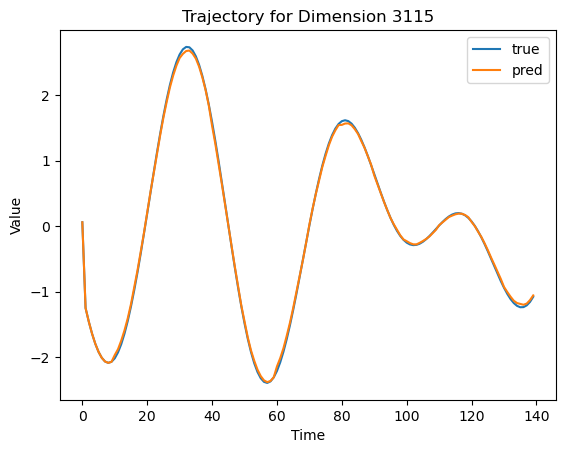

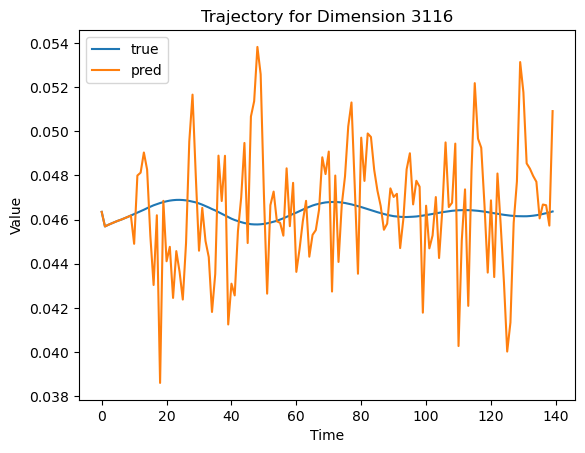

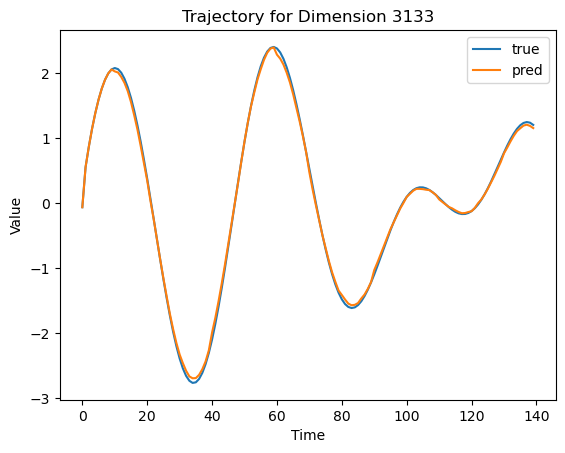

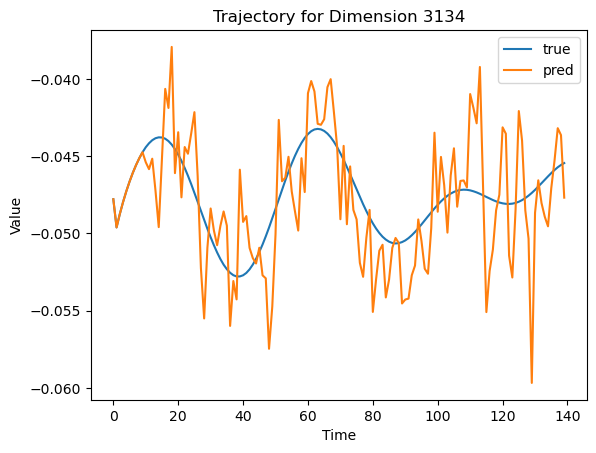

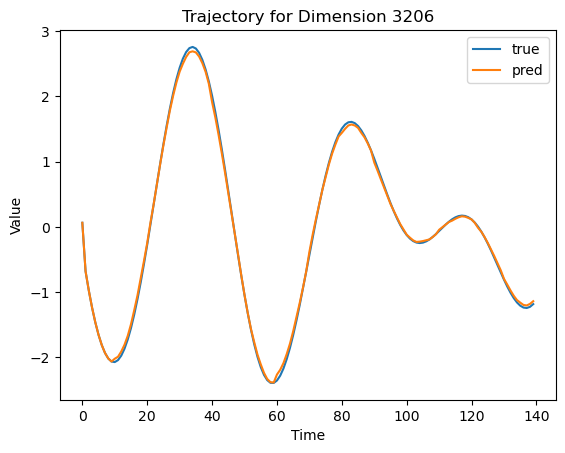

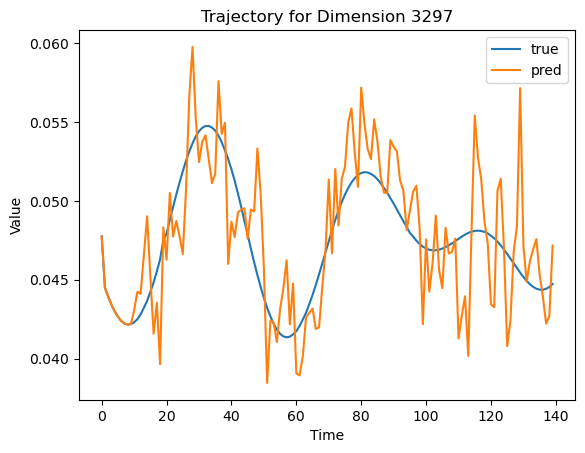

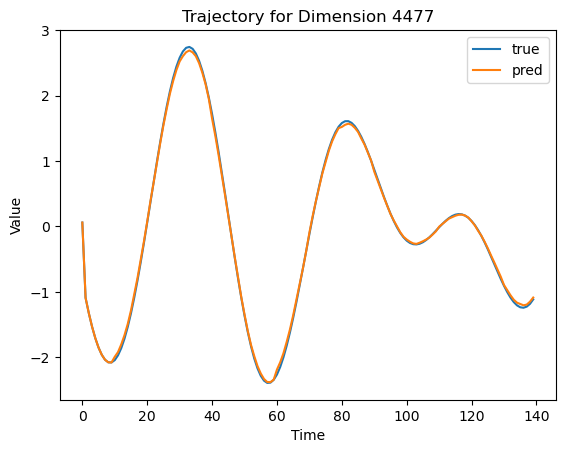

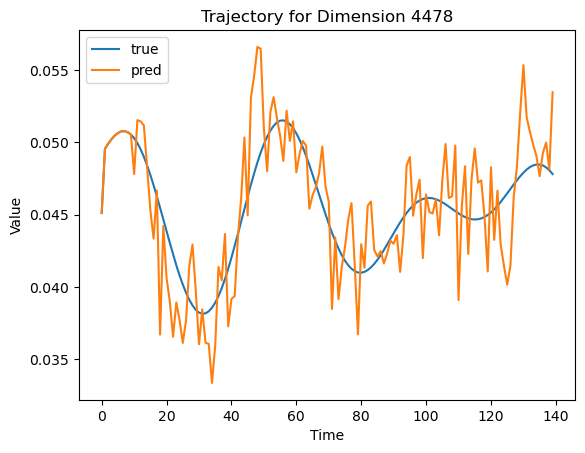

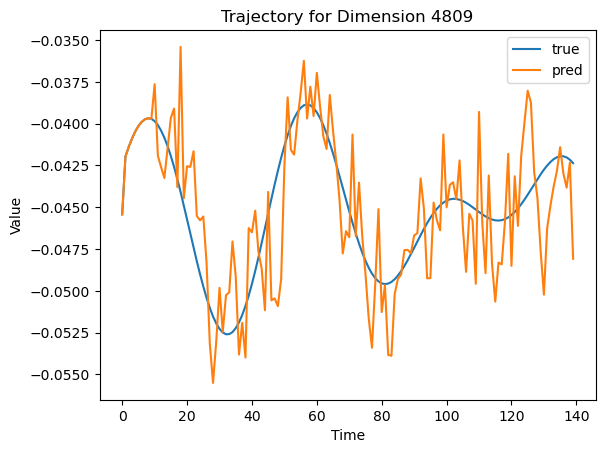

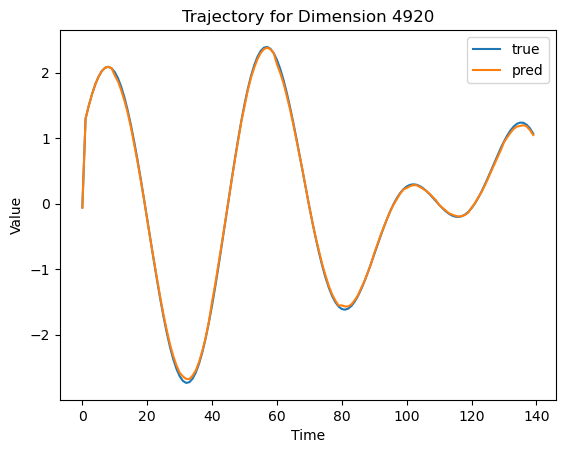

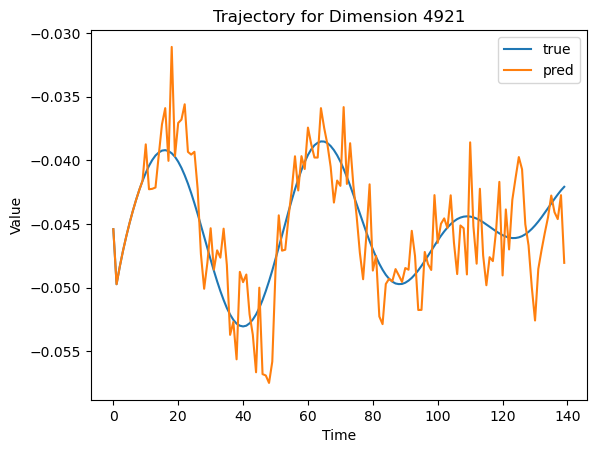

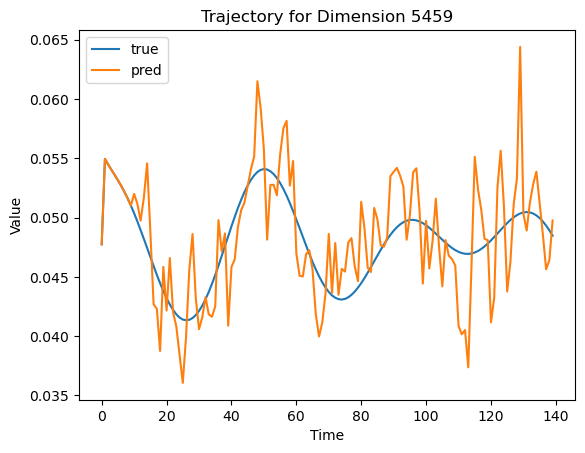

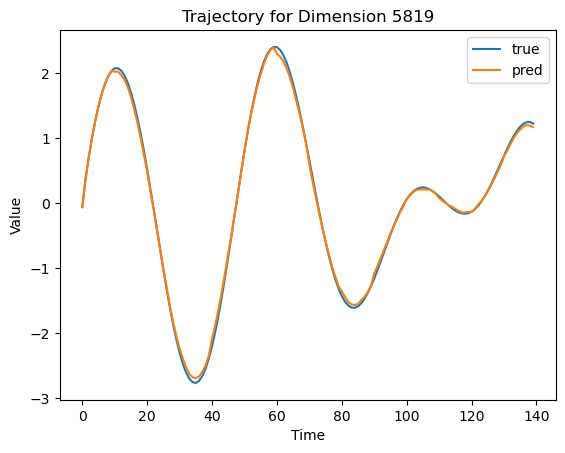

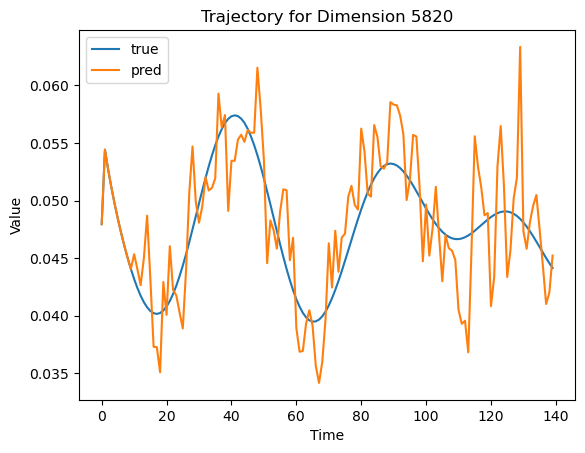

In [34]:
idx = 39
n_dimensions = x_dataset[idx].shape[1]
selected_dimensions = indexes_large_error[0]

for i in selected_dimensions:
    plt.figure()
    y_true = x_dataset_scaled[idx]
    y_pred = y_data_pred_50traj_10predict_scaled[idx]
    plt.plot(y_true[:, i], label = 'true')
    plt.plot(y_pred[:, i], label = 'pred')
    plt.title(f'Trajectory for Dimension {i}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [35]:
mean_ratios_scaled[selected_dimensions]

array([0.03543054, 0.06050334, 0.04425803, 0.07017576, 0.04116463,
       0.06835945, 0.03528547, 0.06213482, 0.06259094, 0.03597872,
       0.06265617, 0.07667823, 0.04991419, 0.08005106])